## Imports


In [1]:
import os
import matplotlib.pyplot as plt

import requests
import tarfile
import os

from tqdm import tqdm

import torch
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torchvision import models
from torch import nn


os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Definition of global constants

In [2]:
IMG_SIZE = (224,224)
IMAGE_PATH = os.path.join(os.getcwd(), 'dataset/images')

## Defining transformations

Defining transforms for images and labels. These are used for preprocessing each image used in the model

## Definition of training/testing loops

We now define the training/test functions as implemented in
https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

In [3]:
def set_bn_to_eval(model):
    """Set all BatchNorm layers to evaluation mode."""
    for layer in model.modules():
        if isinstance(layer, nn.BatchNorm2d):
            layer.eval()

def set_bn_to_eval_and_freeze_parameters(model):
    for layer in model.modules():
        if isinstance(layer, nn.BatchNorm2d):
            layer.eval()
            layer.requires_grad = False

def set_bn_to_train_and_unfreeze_parameters(model):
    for layer in model.modules():
        if isinstance(layer, nn.BatchNorm2d):
            layer.train()
            layer.requires_grad = True

def train_loop(dataloader, model, loss_fn, optimizer, device, DEBUG=True, BN_MODE='FREEZE', **kwargs):
    """
    Trains the model provided for one epoch.

    Args:
        BN_MODE : 'DEFAULT', 'FREEZE', 'UNLOCK_ALL'

    Returns:
        results : {
            'train_loss' : float, this is the average loss over the entire dataset,
            'train_accuracy' : float, this is the accuracy over the entire dataset
        }
    """
    print_every = int(kwargs.get('print_every', 10))
    data_aug = kwargs.get('data_aug', False)

    train_loss = 0
    train_accuracy = 0

    num_batches = len(dataloader)
    model.train()
    if BN_MODE == 'DEFAULT':
        set_bn_to_eval(model)
    elif BN_MODE == 'FREEZE':
        # This will change layers to eval and freeze batch norm parameters
        set_bn_to_eval_and_freeze_parameters(model)
    elif BN_MODE == 'UNLOCK_ALL':
        set_bn_to_train_and_unfreeze_parameters(model)
    else:
        # This will update batch norm mean and variance and update parameters inside unlocked layers
        pass

    model.to(device)

    with tqdm(total=num_batches, dynamic_ncols=True) as pbar:
        for batch, (X, y) in enumerate(dataloader):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)

            if data_aug:
                X = train_transform(X)

            pred = model(X)
            loss = loss_fn(pred, y)

            loss.backward()
            optimizer.step()

            # update loss and accuracy
            train_loss += loss.item()
            train_accuracy += (pred.argmax(1) == y).type(torch.float).sum().item()

            if DEBUG and batch % print_every == 0:
                loss_item = loss.item()
                pbar.set_description(f"loss: {loss_item:>7f}  Batch:[{batch+1:>5d}/{num_batches:>5d}]")
            pbar.update(1)

    train_loss /= num_batches
    train_accuracy /= len(dataloader.dataset)
    return {
        'train_loss' : train_loss,
        'train_accuracy' : train_accuracy
    }

In [4]:
def test_loop(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.to(device)  # Move the model to the device

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # Move the data to the device
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return {'validation_loss': test_loss, 'validation_acc': correct}

In [5]:
def evaluate_model(dataloader, model, loss_fn, device):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    model.to(device)  # Move the model to the device

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)  # Move the data to the device
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    accuracy = 100*correct
    return accuracy, test_loss

## We create a function that creates the datasets and loads the data

In [6]:
import random
from torch.utils.data import Subset
from torchvision.datasets import OxfordIIITPet

def load_data(train_transform=None, val_transform=None):
    if val_transform == None:
        val_transform = train_transform




    training_data = OxfordIIITPet(root='dataset', split='trainval', target_types='category', transform=train_transform, download=True)
    validation_data = OxfordIIITPet(root='dataset', split='trainval', target_types='category', transform=val_transform, download=False)
    test_data = OxfordIIITPet(root='dataset', split='test', target_types='category', transform=val_transform, download=False)

    # shuffle and split into validation and training
    indices = list(range(len(training_data)))
    random.seed(310)  # fix the seed
    random.shuffle(indices)

    train_size = int(0.8 * len(training_data))
    train_dataset_split = Subset(training_data, indices[:train_size])
    val_dataset_split = Subset(validation_data, indices[train_size:])

    return train_dataset_split, val_dataset_split, test_data

## Next we define the training function

In [7]:

def train_model(model, loss_fn, optimizer, train_dataloader, val_dataloader, **kwargs):
    """
    Args:
        **kwargs : {
            'epochs' : int,
            'device' : torch.device,
            'scheduler' : torch.scheduler,
            'data_aug' : bool
        }
    """
    epochs = kwargs.get('epochs', 5)
    device = kwargs.get('device', torch.device('cpu'))
    scheduler = kwargs.get('scheduler', None)
    patience = kwargs.get('patience', 5)

    training_results = []
    validation_results = []
    best_loss = 999
    best_acc = 0
    counter = 0

    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_res = train_loop(train_dataloader, model, loss_fn, optimizer, **kwargs)
        if scheduler is not None:
            scheduler.step()
        val_res = test_loop(val_dataloader, model, loss_fn, device)

        # append data
        training_results.append(train_res)
        validation_results.append(val_res)

        if val_res['validation_loss'] < best_loss:
            best_loss = val_res['validation_loss']
            # save the best loss model
            torch.save(model.state_dict(), 'best_model_loss.pth')
            counter = 0
        else:
            counter += 1
        # save best acc model
        if val_res['validation_acc'] >= best_acc:
            best_acc = val_res['validation_acc']
            torch.save(model.state_dict(), 'best_model_acc.pth')
        # break if not improving for last 5 epochs
        if t > patience and counter == patience:
            print("Early stopping!")
            break
    print("Training done!")

    return {'train_res': training_results, 'val_res': validation_results}

## function for plotting loss and acc

In [8]:
# make one graph for accuracy and one for loss
import seaborn as sns
# use style
sns.set_theme(style='whitegrid')

def create_graphs(results, filename):
    train_loss = [res['train_loss'] for res in results['train_res']]
    val_loss = [res['validation_loss'] for res in results['val_res']]

    train_acc = [res['train_accuracy'] for res in results['train_res']]

    val_acc = [res['validation_acc'] for res in results['val_res']]

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    sns.lineplot(x=range(1, len(train_loss)+1), y=train_loss, ax=ax[0], label='train_loss')
    sns.lineplot(x=range(1, len(val_loss)+1), y=val_loss, ax=ax[0], label='val_loss')

    sns.lineplot(x=range(1, len(train_acc)+1), y=train_acc, ax=ax[1], label='train_acc')
    sns.lineplot(x=range(1, len(val_acc)+1), y=val_acc, ax=ax[1], label='val_acc')

    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')

    ax[0].set_xlabel('Epochs')
    ax[1].set_xlabel('Epochs')

    plt.savefig(filename)


# Extension 1: Deeper networks

Explore using deeper networks than you used in the basic project. Does the deeper network
help? Is it trickier to fine-tune? Do you even need to fine-tune the earlier layers? Do you
need to change the optimizer to for instance AdamW to ensure good training?

### Establish baseline

First we establish a baseline by training the ResNet34 model (only the connected layer at first)

In [9]:
from torchvision import transforms
from torchvision.transforms import v2

from torchvision.models import ResNet34_Weights
from torchvision.models import ResNet152_Weights

# get transforms from resnet
weights = ResNet34_Weights.DEFAULT
resnet34_preprocess = weights.transforms() # this is the preprocessing done by resnet34

# transforms used are those in https://pytorch.org/vision/stable/transforms.html example
# get transforms from resnet
weights = ResNet152_Weights.DEFAULT
resnet152_preprocess = weights.transforms() # this is the preprocessing done by resnet34

#train_transform = v2.RandAugment()

In [10]:
num_classes = 37
# create the model
model = models.resnet34(pretrained=True)

# load data
train_data, val_data, test_data = load_data(train_transform=resnet34_preprocess, val_transform=resnet34_preprocess)

# dataloaders
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

# Change the output layer
in_features = model.fc.in_features
#model.fc = torch.nn.Linear(in_features=in_features, out_features=num_classes, bias=True)
model.fc = nn.Linear(in_features, num_classes, bias=True)

# freeze all layers
for param in model.parameters():
    param.requires_grad = False

# unfreeze fc
for param in model.fc.parameters():
    param.requires_grad = True

# train the model
_epochs = 100
batch_size = 32

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = None

results = train_model(model, nn.CrossEntropyLoss(), optimizer, train_dataloader, val_dataloader, epochs=_epochs, device=device, scheduler=scheduler)
# plot results
create_graphs(results, 'extension_graphs/resnet_34baseline')
print(f"Best achieved validation loss: {min([res['validation_loss'] for res in results['val_res']])}")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 57.8MB/s]


100%|██████████| 791918971/791918971 [00:23<00:00, 33566107.21it/s]


Extracting dataset/oxford-iiit-pet/images.tar.gz to dataset/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 15013619.01it/s]


Extracting dataset/oxford-iiit-pet/annotations.tar.gz to dataset/oxford-iiit-pet
Epoch 1
-------------------------------


loss: 0.873215  Batch:[   91/   92]: 100%|██████████| 92/92 [00:23<00:00,  3.93it/s]


Validation Error: 
 Accuracy: 86.3%, Avg loss: 0.739447 

Epoch 2
-------------------------------


loss: 0.571786  Batch:[   51/   92]:  62%|██████▏   | 57/92 [00:15<00:09,  3.72it/s]


KeyboardInterrupt: 

In [ ]:
base34 = results
# load best loss model
model.load_state_dict(torch.load('best_model_loss.pth'))
# save model
torch.save(model.state_dict(), 'resnet34_baseline.pth')

### Deeper networks

First we create the baseline but train with a deeper network

Epoch 1
-------------------------------


loss: 0.978141  Batch:[   91/   92]: 100%|██████████| 92/92 [00:31<00:00,  2.92it/s]


Validation Error: 
 Accuracy: 91.7%, Avg loss: 1.005983 

Epoch 2
-------------------------------


loss: 0.414326  Batch:[   91/   92]: 100%|██████████| 92/92 [00:30<00:00,  2.99it/s]


Validation Error: 
 Accuracy: 92.5%, Avg loss: 0.520297 

Epoch 3
-------------------------------


loss: 0.282796  Batch:[   91/   92]: 100%|██████████| 92/92 [00:31<00:00,  2.96it/s]


Validation Error: 
 Accuracy: 93.1%, Avg loss: 0.375228 

Epoch 4
-------------------------------


loss: 0.154267  Batch:[   91/   92]: 100%|██████████| 92/92 [00:31<00:00,  2.90it/s]


Validation Error: 
 Accuracy: 93.8%, Avg loss: 0.312753 

Epoch 5
-------------------------------


loss: 0.091832  Batch:[   91/   92]: 100%|██████████| 92/92 [00:30<00:00,  2.99it/s]


Validation Error: 
 Accuracy: 93.8%, Avg loss: 0.275014 

Epoch 6
-------------------------------


loss: 0.109939  Batch:[   91/   92]: 100%|██████████| 92/92 [00:31<00:00,  2.97it/s]


Validation Error: 
 Accuracy: 93.8%, Avg loss: 0.255514 

Epoch 7
-------------------------------


loss: 0.086184  Batch:[   91/   92]: 100%|██████████| 92/92 [00:30<00:00,  2.98it/s]


Validation Error: 
 Accuracy: 93.6%, Avg loss: 0.235402 

Epoch 8
-------------------------------


loss: 0.088889  Batch:[   91/   92]: 100%|██████████| 92/92 [00:32<00:00,  2.79it/s]


Validation Error: 
 Accuracy: 94.0%, Avg loss: 0.227373 

Epoch 9
-------------------------------


loss: 0.060228  Batch:[   91/   92]: 100%|██████████| 92/92 [00:34<00:00,  2.70it/s]


Validation Error: 
 Accuracy: 94.0%, Avg loss: 0.218628 

Epoch 10
-------------------------------


loss: 0.055463  Batch:[   91/   92]: 100%|██████████| 92/92 [00:32<00:00,  2.80it/s]


Validation Error: 
 Accuracy: 94.0%, Avg loss: 0.214583 

Epoch 11
-------------------------------


loss: 0.033377  Batch:[   91/   92]: 100%|██████████| 92/92 [00:31<00:00,  2.91it/s]


Validation Error: 
 Accuracy: 94.0%, Avg loss: 0.203997 

Epoch 12
-------------------------------


loss: 0.047146  Batch:[   91/   92]: 100%|██████████| 92/92 [00:32<00:00,  2.85it/s]


Validation Error: 
 Accuracy: 94.3%, Avg loss: 0.202043 

Epoch 13
-------------------------------


loss: 0.055282  Batch:[   91/   92]: 100%|██████████| 92/92 [00:33<00:00,  2.78it/s]


Validation Error: 
 Accuracy: 94.0%, Avg loss: 0.198141 

Epoch 14
-------------------------------


loss: 0.024780  Batch:[   91/   92]: 100%|██████████| 92/92 [00:32<00:00,  2.87it/s]


Validation Error: 
 Accuracy: 94.6%, Avg loss: 0.194312 

Epoch 15
-------------------------------


loss: 0.024713  Batch:[   91/   92]: 100%|██████████| 92/92 [00:33<00:00,  2.76it/s]


Validation Error: 
 Accuracy: 93.9%, Avg loss: 0.190758 

Epoch 16
-------------------------------


loss: 0.018848  Batch:[   91/   92]: 100%|██████████| 92/92 [00:32<00:00,  2.79it/s]


Validation Error: 
 Accuracy: 93.9%, Avg loss: 0.191158 

Epoch 17
-------------------------------


loss: 0.021094  Batch:[   91/   92]: 100%|██████████| 92/92 [00:32<00:00,  2.82it/s]


Validation Error: 
 Accuracy: 94.3%, Avg loss: 0.190808 

Epoch 18
-------------------------------


loss: 0.012205  Batch:[   91/   92]: 100%|██████████| 92/92 [00:33<00:00,  2.78it/s]


Validation Error: 
 Accuracy: 94.3%, Avg loss: 0.186903 

Epoch 19
-------------------------------


loss: 0.014315  Batch:[   91/   92]: 100%|██████████| 92/92 [00:32<00:00,  2.84it/s]


Validation Error: 
 Accuracy: 94.2%, Avg loss: 0.185835 

Epoch 20
-------------------------------


loss: 0.012218  Batch:[   91/   92]: 100%|██████████| 92/92 [00:32<00:00,  2.79it/s]


Validation Error: 
 Accuracy: 94.3%, Avg loss: 0.186900 

Epoch 21
-------------------------------


loss: 0.024199  Batch:[   91/   92]: 100%|██████████| 92/92 [00:31<00:00,  2.91it/s]


Validation Error: 
 Accuracy: 94.6%, Avg loss: 0.184907 

Epoch 22
-------------------------------


loss: 0.012445  Batch:[   91/   92]: 100%|██████████| 92/92 [00:31<00:00,  2.94it/s]


Validation Error: 
 Accuracy: 94.4%, Avg loss: 0.183407 

Epoch 23
-------------------------------


loss: 0.014572  Batch:[   91/   92]: 100%|██████████| 92/92 [00:31<00:00,  2.92it/s]


Validation Error: 
 Accuracy: 94.2%, Avg loss: 0.183899 

Epoch 24
-------------------------------


loss: 0.012713  Batch:[   91/   92]: 100%|██████████| 92/92 [00:31<00:00,  2.97it/s]


Validation Error: 
 Accuracy: 94.4%, Avg loss: 0.182219 

Epoch 25
-------------------------------


loss: 0.012870  Batch:[   91/   92]: 100%|██████████| 92/92 [00:30<00:00,  2.97it/s]


Validation Error: 
 Accuracy: 94.6%, Avg loss: 0.182268 

Epoch 26
-------------------------------


loss: 0.014697  Batch:[   91/   92]: 100%|██████████| 92/92 [00:30<00:00,  2.97it/s]


Validation Error: 
 Accuracy: 94.4%, Avg loss: 0.182820 

Epoch 27
-------------------------------


loss: 0.015365  Batch:[   91/   92]: 100%|██████████| 92/92 [00:30<00:00,  2.97it/s]


Validation Error: 
 Accuracy: 94.2%, Avg loss: 0.182309 

Epoch 28
-------------------------------


loss: 0.016027  Batch:[   91/   92]: 100%|██████████| 92/92 [00:30<00:00,  2.99it/s]


Validation Error: 
 Accuracy: 94.3%, Avg loss: 0.182060 

Epoch 29
-------------------------------


loss: 0.013965  Batch:[   91/   92]: 100%|██████████| 92/92 [00:31<00:00,  2.95it/s]


Validation Error: 
 Accuracy: 94.4%, Avg loss: 0.181848 

Epoch 30
-------------------------------


loss: 0.015031  Batch:[   91/   92]: 100%|██████████| 92/92 [00:31<00:00,  2.93it/s]


Validation Error: 
 Accuracy: 94.3%, Avg loss: 0.181020 

Training done!
Best achieved validation loss: 0.18102023815331253


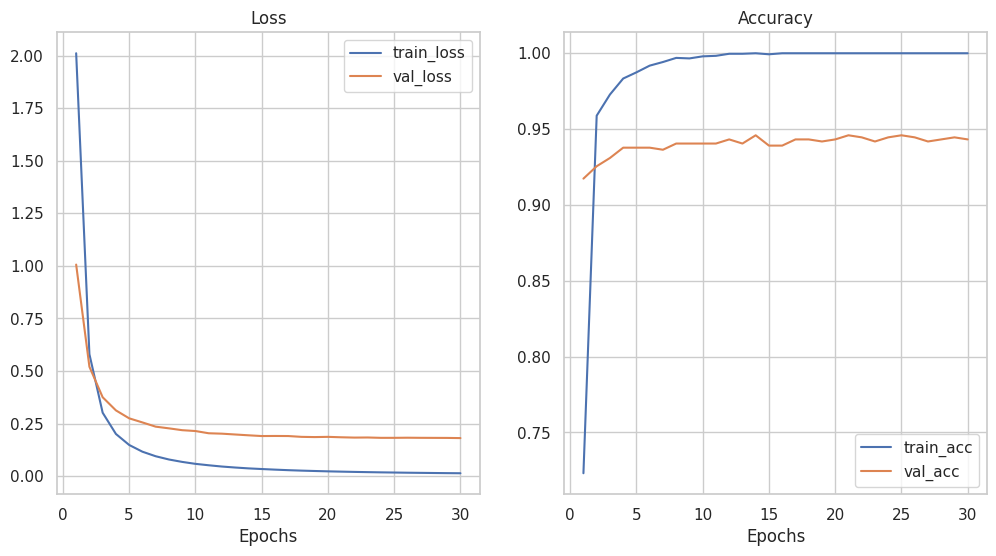

In [13]:
num_classes = 37
# create the model
model = models.resnet152(weights='DEFAULT')

# load data
train_data, val_data, test_data = load_data(train_transform=resnet152_preprocess, val_transform=resnet152_preprocess)

# dataloaders
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=2)

# Change the output layer
in_features = model.fc.in_features
#model.fc = torch.nn.Linear(in_features=in_features, out_features=num_classes, bias=True)
model.fc = nn.Linear(in_features, num_classes, bias=True)

# freeze all layers
for param in model.parameters():
    param.requires_grad = False

# unfreeze fc
for param in model.fc.parameters():
    param.requires_grad = True

# train the model
_epochs = 30
batch_size = 32

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

scheduler = None

results = train_model(model, nn.CrossEntropyLoss(), optimizer, train_dataloader, val_dataloader, epochs=_epochs, device=device, scheduler=scheduler)
# plot results
create_graphs(results, 'extension_graphs/resnet_152baseline')
# print best achieved validation loss
print(f"Best achieved validation loss: {min([res['validation_loss'] for res in results['val_res']])}")

In [14]:
base152 = results
# load best loss model
model.load_state_dict(torch.load('best_model_loss.pth'))
# save model
torch.save(model.state_dict(), 'resnet152_baseline.pth')

In [15]:
accuracy, test_loss = evaluate_model(test_dataloader, model, nn.CrossEntropyLoss(), device)

print(f"Test Accuracy: {accuracy:.2f}%, Test loss: {test_loss}")

Test Accuracy: 92.40%, Test loss: 0.24653369798729924
